# Answering buisness questions using SQL
- Write a SQL query to extract the relevant data
- Create plots where necessary to visualize the data
- Write a short paragraph, drawing conclusions and - explaining the data and/or visualizations.

## Creating Helper functions

In [1]:
# import block
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline

In [2]:
db = 'chinook.db'

# function takes a sql query as an argument 
# and returns a pandas dataframe of tha query
def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql(q, conn)

# function takes a sql command as an argument
# and executes it using the sqlite module
def run_command(c):
    with sql.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
# function calls run_query() function 
# to return a list of all tables and views in the database
def show_tables():
    q = """
    select 
        name,
        type
    from sqlite_master
    where type in ("table", "view");
    """
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting albums to purchase

In [4]:
q_pur_usa= """
with
    inv_gen
    as
    (
        select
            il.invoice_id,
            t.track_id,
            g.name genre
        from track t
            inner join genre g on g.genre_id=t.genre_id
            inner join invoice_line il on il.track_id=t.track_id
    ),
    sales_usa
    as
    (
        select
            invoice_id,
            billing_country
        from invoice
        where billing_country='USA'
    ),
    num_of_tracks
    as
    (
        select
            ig.genre,
            count(ig.track_id) tracks_sold
        from inv_gen ig
            inner join sales_usa su on su.invoice_id=ig.invoice_id
        group by 1
    )
select nt.*,
    cast(nt.tracks_sold as float)/(select sum(tracks_sold)
    from num_of_tracks)*100 share
from num_of_tracks nt
order by 3 desc
limit 10

"""
run_query(q_pur_usa)

,genre,tracks_sold,share
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


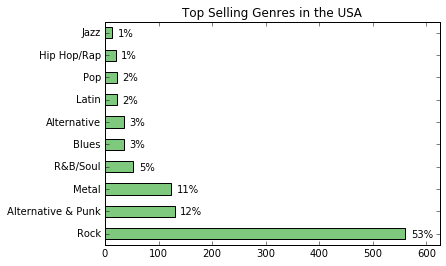

In [5]:
genre_usa_sales = run_query(q_pur_usa)
genre_usa_sales.set_index('genre', inplace=True, drop=True)

genre_usa_sales['tracks_sold'].plot.barh(
    title='Top Selling Genres in the USA',
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_usa_sales.index)):
    score = genre_usa_sales.loc[label, 'tracks_sold']
    label = (genre_usa_sales.loc[label, 'share'].astype(int).astype(str) 
             + '%')
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# Analyzing Employee Sales Performance

In [6]:
q_emp_perform = """
with
    cust_sup_rep_sales
    as
    (
        select
            c.support_rep_id,
            sum(i.total) total_sales
        from invoice i
            inner join customer c on c.customer_id=i.customer_id
        group by 1
    )
select
    e.first_name || ' ' || e.last_name full_name,
    e.hire_date,
    c.total_sales
from employee e
    inner join cust_sup_rep_sales c on c.support_rep_id=e.employee_id
"""

# employee, customer (customer_id, suppert_rep_id), invoice (customer_id, total)
run_query(q_emp_perform)

,full_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


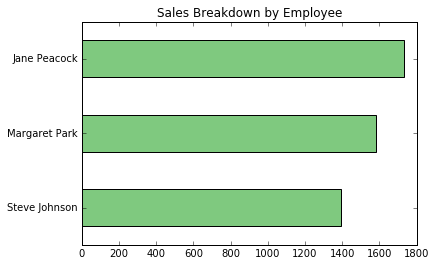

In [7]:
employee_sales = run_query(q_emp_perform)
employee_sales.set_index('full_name', inplace=True, drop=True)
employee_sales.sort_values('total_sales', inplace=True)

employee_sales['total_sales'].plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# Analyzing Sales by Counry

In [8]:
sales_by_country = """
with
    country_or_other
    as
    (
        select
            case 
            when (
                select count(*)
            from customer
            where country=c.country
                )=1 then 'Other'
            else c.country
            end country,
            i.*,
            il.*
        from invoice_line il
            inner join invoice i on i.invoice_id=il.invoice_line_id
            inner join customer c on c.customer_id=i.customer_id
    ),
    totals
    as
    (
        select
            country,
            count(distinct customer_id) customers,
            sum(total) total_sales,
            sum(total) / count(distinct customer_id) average_sales,
            sum(total) / count(distinct invoice_id) average_order,
            case 
                when country='Other' then 1
                else 0
            end sort
        from country_or_other
        group by 1
        order by 6, 2 desc
    )
select
    country,
    customers,
    total_sales,
    average_sales,
    average_order
from totals
    
"""
run_query(sales_by_country)

,country,customers,total_sales,average_sales,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


# Visualizing Sales by Country

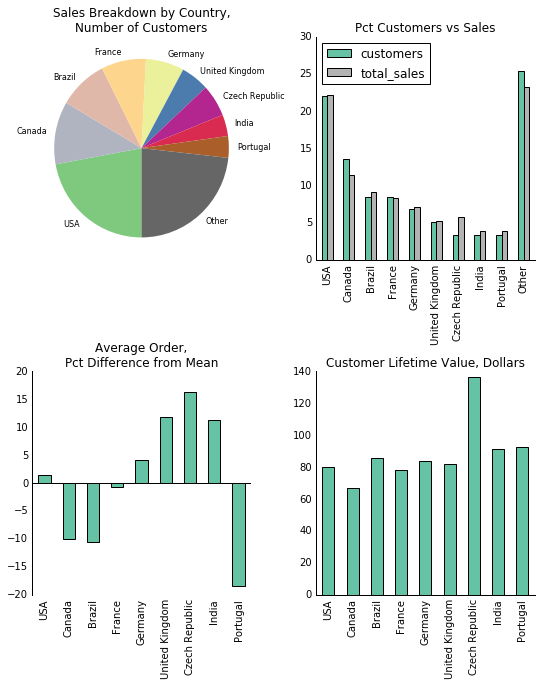

In [15]:
# create dataframe
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country', inplace=True, drop=True)

# set figure settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,10)) 
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_brakdown = country_metrics['total_sales'].copy().rename('')
sales_brakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

# top right
cvd_cols = ['customers', 'total_sales']
cuts_vs_dollars = country_metrics[cvd_cols].copy()
cuts_vs_dollars.index.name=''

for col in cvd_cols:
    cuts_vs_dollars[col] /= country_metrics[col].sum() / 100
    
cuts_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set2,
    title='Pct Customers vs Sales'
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name=''
diff_from_avg = avg_order * 100 / avg_order.mean() - 100
diff_from_avg.drop("Other", inplace=True)
diff_from_avg.plot.bar(
    ax=ax3,
    colormap=plt.cm.Set2,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["average_sales"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    colormap=plt.cm.Set2,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()


Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Albums vs Individual Tracks

In [24]:
q_albums = """

with
    invoice_firs_track
    as
    (
        select
            invoice_id,
            min(track_id) first_track_id
        from invoice_line
        group by 1
    )


select album_purchase,
    count(invoice_id) number_of_invoices,
    cast(count(invoice_id) as float) / (select count(*)
    from invoice)
percent 
from
(
select ifs.*,
    case
when (

                                    select t.track_id
            from track t
            where t.album_id = (
            select t2.album_id
            from track t2
            where t2.track_id=ifs.first_track_id
            )
        except
            select il2.track_id
            from invoice_line il2
            where il2.invoice_id = ifs.invoice_id

) is null
and
        (  
            select il2.track_id
            from invoice_line il2
            where il2.invoice_id = ifs.invoice_id

        except
            select t.track_id
            from track t
            where t.album_id = (
            select t2.album_id
            from track t2
            where t2.track_id=ifs.first_track_id
            )
) is null

then 'yes'
else 'no'
end album_purchase
from invoice_firs_track ifs
)
group by album_purchase
"""

run_query(q_albums)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
